# Generating Figures from COPD Research Paper

This notebook uses the synthetic dataset (`synthetic_data.xlsx`) to recreate figures from the research paper *Deep Learning for Detecting and Early Predicting Chronic Obstructive Pulmonary Disease from Spirogram Time Series: A UK Biobank Study*. The figures include spirometry curves, ROC curves, concavity analyses, and subgroup comparisons. The code processes the `flow` column to plot Time-Volume and Flow-Volume curves, applies smoothing, and simulates model predictions using FEV1/FVC ratios.

## Prerequisites
- Ensure `synthetic_data.xlsx` is in the same directory.
- Install required libraries: `pip install pandas numpy matplotlib scipy scikit-learn`.

## Figures Generated
- **Figure 9**: Time-Volume and Flow-Volume curves with smoothing effects.
- **Figure 10**: Flow-Volume curves for healthy and COPD patients with phase markers.
- **Figure 2**: Simulated ROC curve using FEV1/FVC ratio.
- **Figure 4**: Simplified concavity degree vs. COPD probability.
- **Figure 5**: Subgroup analysis by smoking, sex, and age.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve, auc

# Load the synthetic data
df = pd.read_excel('./data/train/synthetic_data.xlsx')

# Function to parse and compute curves
def parse_and_compute(row, total_time=6.0, num_points=51):
    flow_str = row['flow']
    volume_mL = np.array([int(x) for x in flow_str.split(',')])
    volume = volume_mL / 1000.0  # Convert to liters
    dt = total_time / (num_points - 1)
    time = np.linspace(0, total_time, num_points)
    flow_rate = np.diff(volume) / dt  # Liters per second
    return time, volume, flow_rate

# Function to compute concavity (simplified as curvature)
def compute_concavity(volume, flow_rate):
    # Approximate second derivative of flow w.r.t. volume
    d_flow = np.diff(flow_rate)
    d_volume = np.diff(volume[1:])
    curvature = np.abs(d_flow / d_volume) if np.all(d_volume != 0) else np.zeros_like(d_flow)
    return np.mean(curvature)  # Average curvature as concavity measure

## Figure 9: Spirometry Curve and Smoothing Effects

This section generates plots similar to Figure 9, showing Time-Volume, Time-Flow, and Flow-Volume curves for a sample patient, with original and smoothed versions to demonstrate smoothing effects.

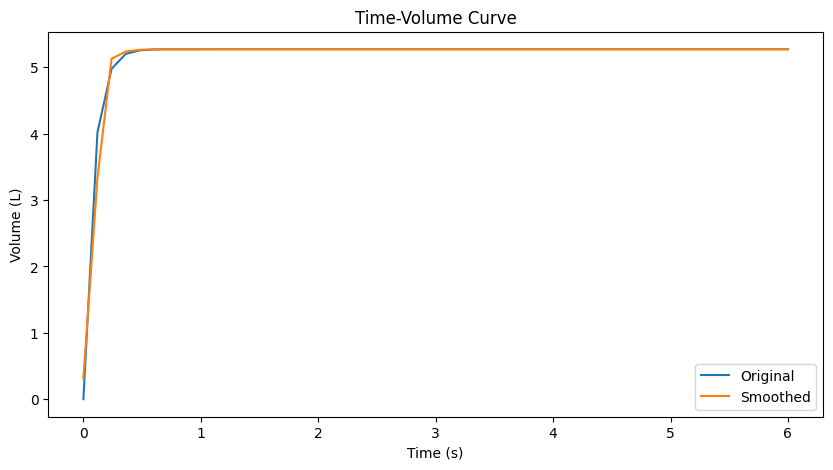

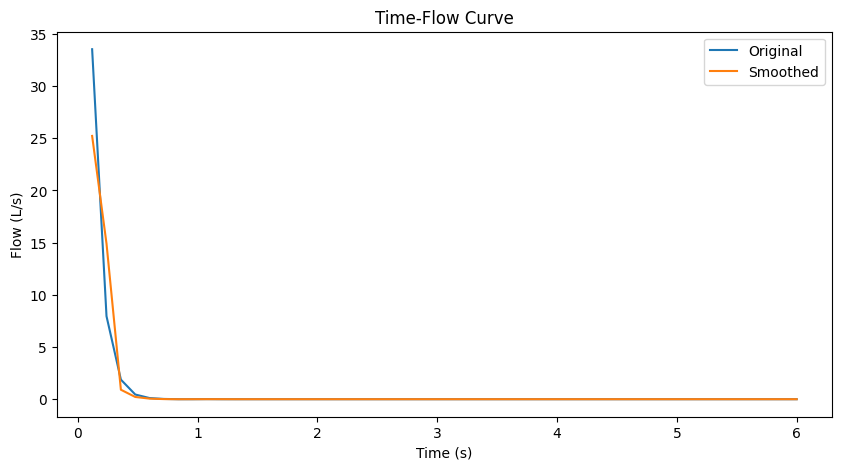

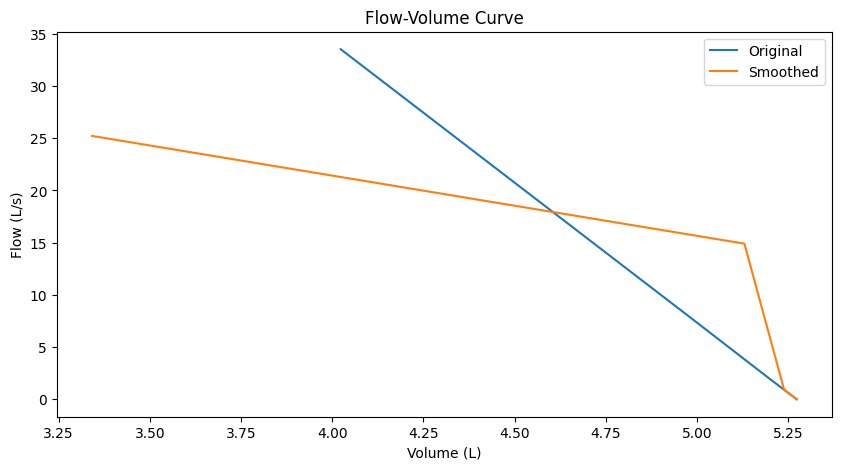

In [2]:
# Select a sample row
row = df.iloc[0]
time, volume, flow_rate = parse_and_compute(row)

# Smooth the volume data
window_length = 5
polyorder = 2
volume_smoothed = savgol_filter(volume, window_length, polyorder)
flow_rate_smoothed = np.diff(volume_smoothed) / (time[1] - time[0])

# Plot Time-Volume Curve
plt.figure(figsize=(10, 5))
plt.plot(time, volume, label='Original')
plt.plot(time, volume_smoothed, label='Smoothed')
plt.xlabel('Time (s)')
plt.ylabel('Volume (L)')
plt.title('Time-Volume Curve')
plt.legend()
plt.show()

# Plot Time-Flow Curve
plt.figure(figsize=(10, 5))
plt.plot(time[1:], flow_rate, label='Original')
plt.plot(time[1:], flow_rate_smoothed, label='Smoothed')
plt.xlabel('Time (s)')
plt.ylabel('Flow (L/s)')
plt.title('Time-Flow Curve')
plt.legend()
plt.show()

# Plot Flow-Volume Curve
plt.figure(figsize=(10, 5))
plt.plot(volume[1:], flow_rate, label='Original')
plt.plot(volume_smoothed[1:], flow_rate_smoothed, label='Smoothed')
plt.xlabel('Volume (L)')
plt.ylabel('Flow (L/s)')
plt.title('Flow-Volume Curve')
plt.legend()
plt.show()

## Figure 10: Volume-Flow Curves with Phase-Specific Concavity

This section generates Flow-Volume curves for a healthy and a COPD patient, with markers at 25%, 50%, and 75% of FVC to indicate phases (early, mid-early, mid-late, late).

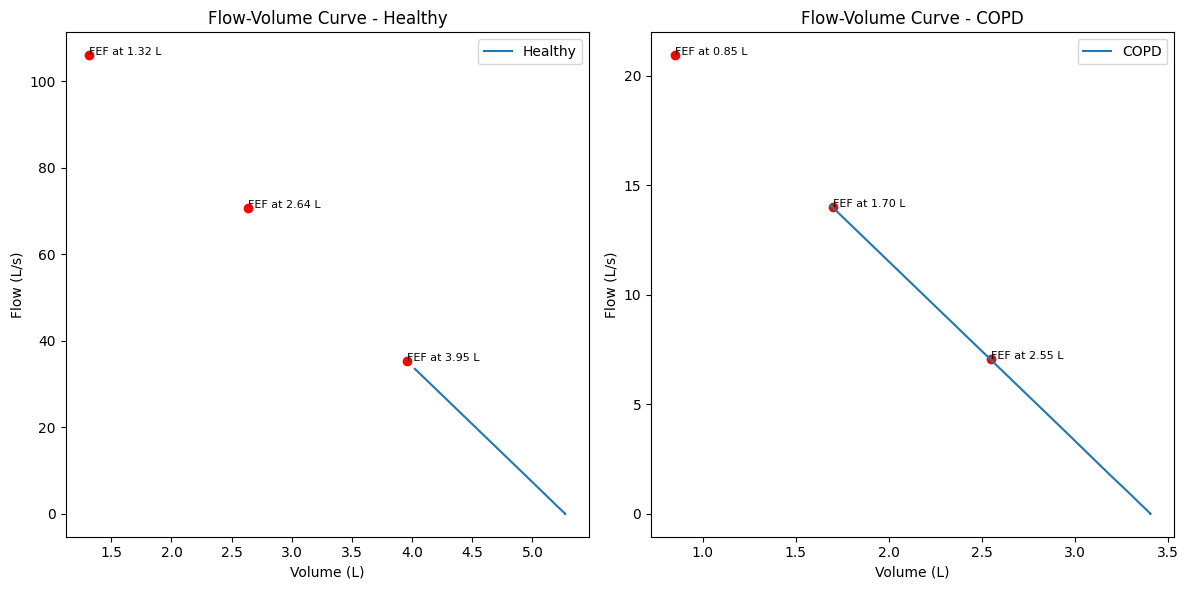

In [3]:
# Select healthy and COPD rows
healthy_row = df[df['COPD'] == 0].iloc[0]
copd_row = df[df['COPD'] == 1].iloc[0] if not df[df['COPD'] == 1].empty else df.iloc[1]

# Compute for healthy
time_h, volume_h, flow_rate_h = parse_and_compute(healthy_row)
FVC_h = healthy_row['FVC']
volumes_to_mark_h = [0.25 * FVC_h, 0.5 * FVC_h, 0.75 * FVC_h]
f_h = interp1d(volume_h[1:], flow_rate_h, kind='linear', fill_value="extrapolate")
flow_at_mark_h = [f_h(v) for v in volumes_to_mark_h]

# Compute for COPD
time_c, volume_c, flow_rate_c = parse_and_compute(copd_row)
FVC_c = copd_row['FVC']
volumes_to_mark_c = [0.25 * FVC_c, 0.5 * FVC_c, 0.75 * FVC_c]
f_c = interp1d(volume_c[1:], flow_rate_c, kind='linear', fill_value="extrapolate")
flow_at_mark_c = [f_c(v) for v in volumes_to_mark_c]

# Plot Flow-Volume Curves
plt.figure(figsize=(12, 6))

# Healthy
plt.subplot(1, 2, 1)
plt.plot(volume_h[1:], flow_rate_h, label='Healthy')
for v, flow in zip(volumes_to_mark_h, flow_at_mark_h):
    plt.scatter(v, flow, color='red')
    plt.text(v, flow, f'FEF at {v:.2f} L', fontsize=8)
plt.xlabel('Volume (L)')
plt.ylabel('Flow (L/s)')
plt.title('Flow-Volume Curve - Healthy')
plt.legend()

# COPD
plt.subplot(1, 2, 2)
plt.plot(volume_c[1:], flow_rate_c, label='COPD')
for v, flow in zip(volumes_to_mark_c, flow_at_mark_c):
    plt.scatter(v, flow, color='red')
    plt.text(v, flow, f'FEF at {v:.2f} L', fontsize=8)
plt.xlabel('Volume (L)')
plt.ylabel('Flow (L/s)')
plt.title('Flow-Volume Curve - COPD')
plt.legend()

plt.tight_layout()
plt.show()

## Figure 2: Simulated ROC Curve

This section simulates an ROC curve using the FEV1/FVC ratio as a predictor of COPD, approximating the paper's model performance comparison.

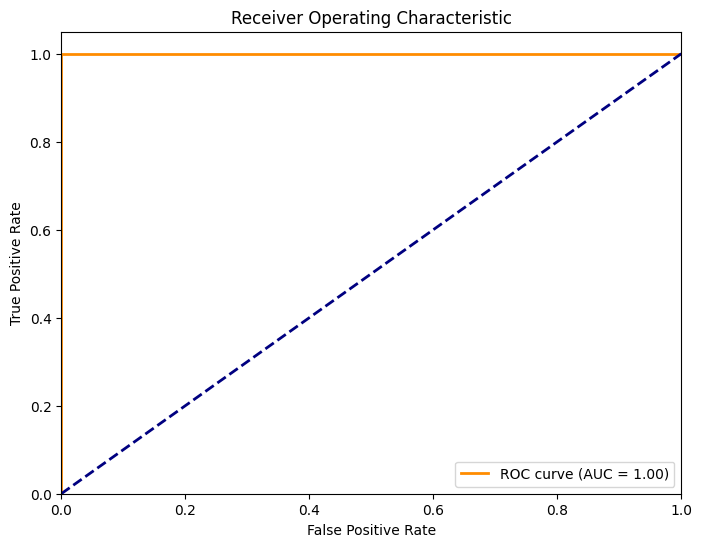

In [4]:
# Compute FEV1/FVC ratio
df['FEV1_FVC'] = df['FEV1'] / df['FVC']

# Simulate ROC curve
y_true = df['COPD']
y_score = 1 - df['FEV1_FVC']  # Lower ratio indicates higher risk
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Figure 4: Future COPD Prediction (Simplified)

This section plots a simplified version of Figure 4, showing concavity degree versus simulated COPD probability.

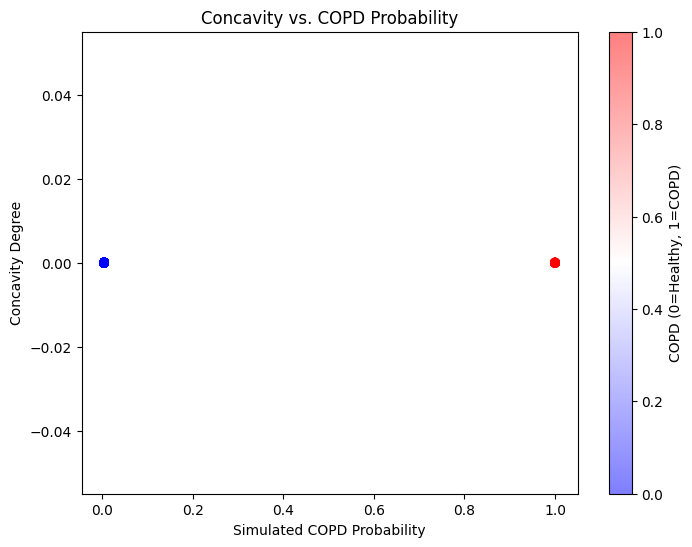

In [5]:
# Compute concavity for each row
concavities = []
for idx, row in df.iterrows():
    _, volume, flow_rate = parse_and_compute(row)
    concavity = compute_concavity(volume, flow_rate)
    concavities.append(concavity)
df['concavity'] = concavities

# Simulate COPD probability (using normalized FEV1/FVC)
df['COPD_prob'] = (1 - df['FEV1_FVC']) / (1 - df['FEV1_FVC'].min())

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(df['COPD_prob'], df['concavity'], c=df['COPD'], cmap='bwr', alpha=0.5)
plt.xlabel('Simulated COPD Probability')
plt.ylabel('Concavity Degree')
plt.title('Concavity vs. COPD Probability')
plt.colorbar(label='COPD (0=Healthy, 1=COPD)')
plt.show()

## Figure 5: Subgroup Analysis

This section generates box plots comparing concavity measures across smoking status, sex, and age groups.

C:\Users\Chetan Vemula\AppData\Local\Temp\ipykernel_10100\3367167526.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 2)
C:\Users\Chetan Vemula\AppData\Local\Temp\ipykernel_10100\3367167526.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 3)


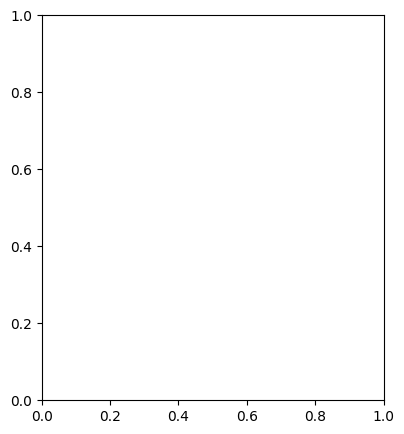

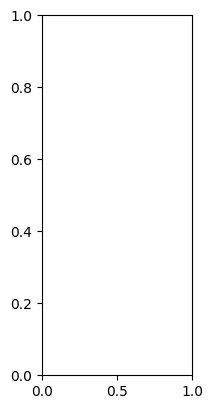

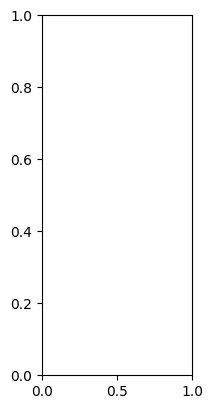

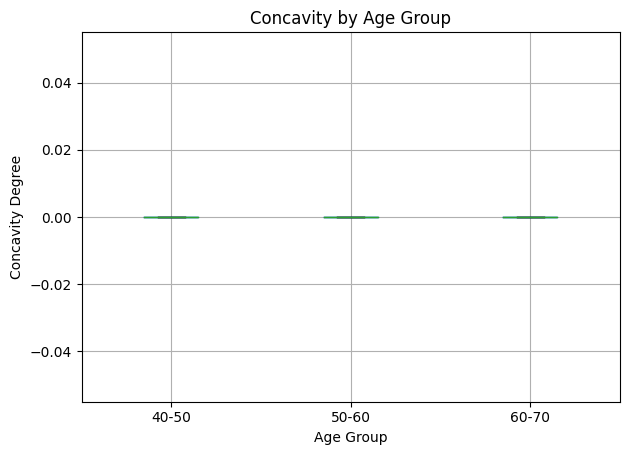

In [6]:
# Define age groups
df['age_group'] = pd.cut(df['age'], bins=[40, 50, 60, 70], labels=['40-50', '50-60', '60-70'])

# Plot subgroup analysis
plt.figure(figsize=(15, 5))

# Smoking
plt.subplot(1, 3, 1)
df.boxplot(column='concavity', by='smoking')
plt.title('Concavity by Smoking Status')
plt.xlabel('Smoking (0=Non-smoker, 1=Smoker)')
plt.ylabel('Concavity Degree')
plt.suptitle('')

# Sex
plt.subplot(1, 3, 2)
df.boxplot(column='concavity', by='sex')
plt.title('Concavity by Sex')
plt.xlabel('Sex (0=Female, 1=Male)')
plt.ylabel('Concavity Degree')
plt.suptitle('')

# Age
plt.subplot(1, 3, 3)
df.boxplot(column='concavity', by='age_group')
plt.title('Concavity by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Concavity Degree')
plt.suptitle('')

plt.tight_layout()
plt.show()